# The code for VAE is inspired from this URL:
https://medium.com/dataseries/variational-autoencoder-with-pytorch-2d359cbf027b
https://avandekleut.github.io/vae/

## Problem 2:

In [5]:
import torchvision
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
import pandas as pd
from random import sample
from torch.autograd import Variable 
from random import randint

import pickle as pkl

import matplotlib.pyplot as plt

In [6]:
#use gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [8]:

def read_file(filename):
    with open(filename, 'rb') as f:
        data = pkl.load(f)

        return data

In [9]:
file_tr = 'hw5_tr7.pkl'
file_te = 'hw5_te7.pkl'

train_file = read_file(file_tr)
test_file = read_file(file_te)


 Epoch 0: train loss 554324.7633928572

 Epoch 1: train loss 467033.72541099775

 Epoch 2: train loss 464514.7163755714

 Epoch 3: train loss 464202.4987222313

 Epoch 4: train loss 464004.24501940055

 Epoch 5: train loss 463947.7705062603

 Epoch 6: train loss 463836.24164494063

 Epoch 7: train loss 463856.1022979356

 Epoch 8: train loss 463709.16258607834

 Epoch 9: train loss 463562.5936025568

 Epoch 10: train loss 463647.8209301993

 Epoch 11: train loss 463686.0514730984

 Epoch 12: train loss 463670.643922192

 Epoch 13: train loss 463538.4080384475

 Epoch 14: train loss 463573.1607426738

 Epoch 15: train loss 463499.6121744869

 Epoch 16: train loss 463450.2641813411

 Epoch 17: train loss 463419.04164375144

 Epoch 18: train loss 463412.29952013894

 Epoch 19: train loss 463402.4658157959

 Epoch 20: train loss 463360.91810818727

 Epoch 21: train loss 463333.49175568554

 Epoch 22: train loss 463271.00582151883

 Epoch 23: train loss 463257.78382256377

 Epoch 24: train

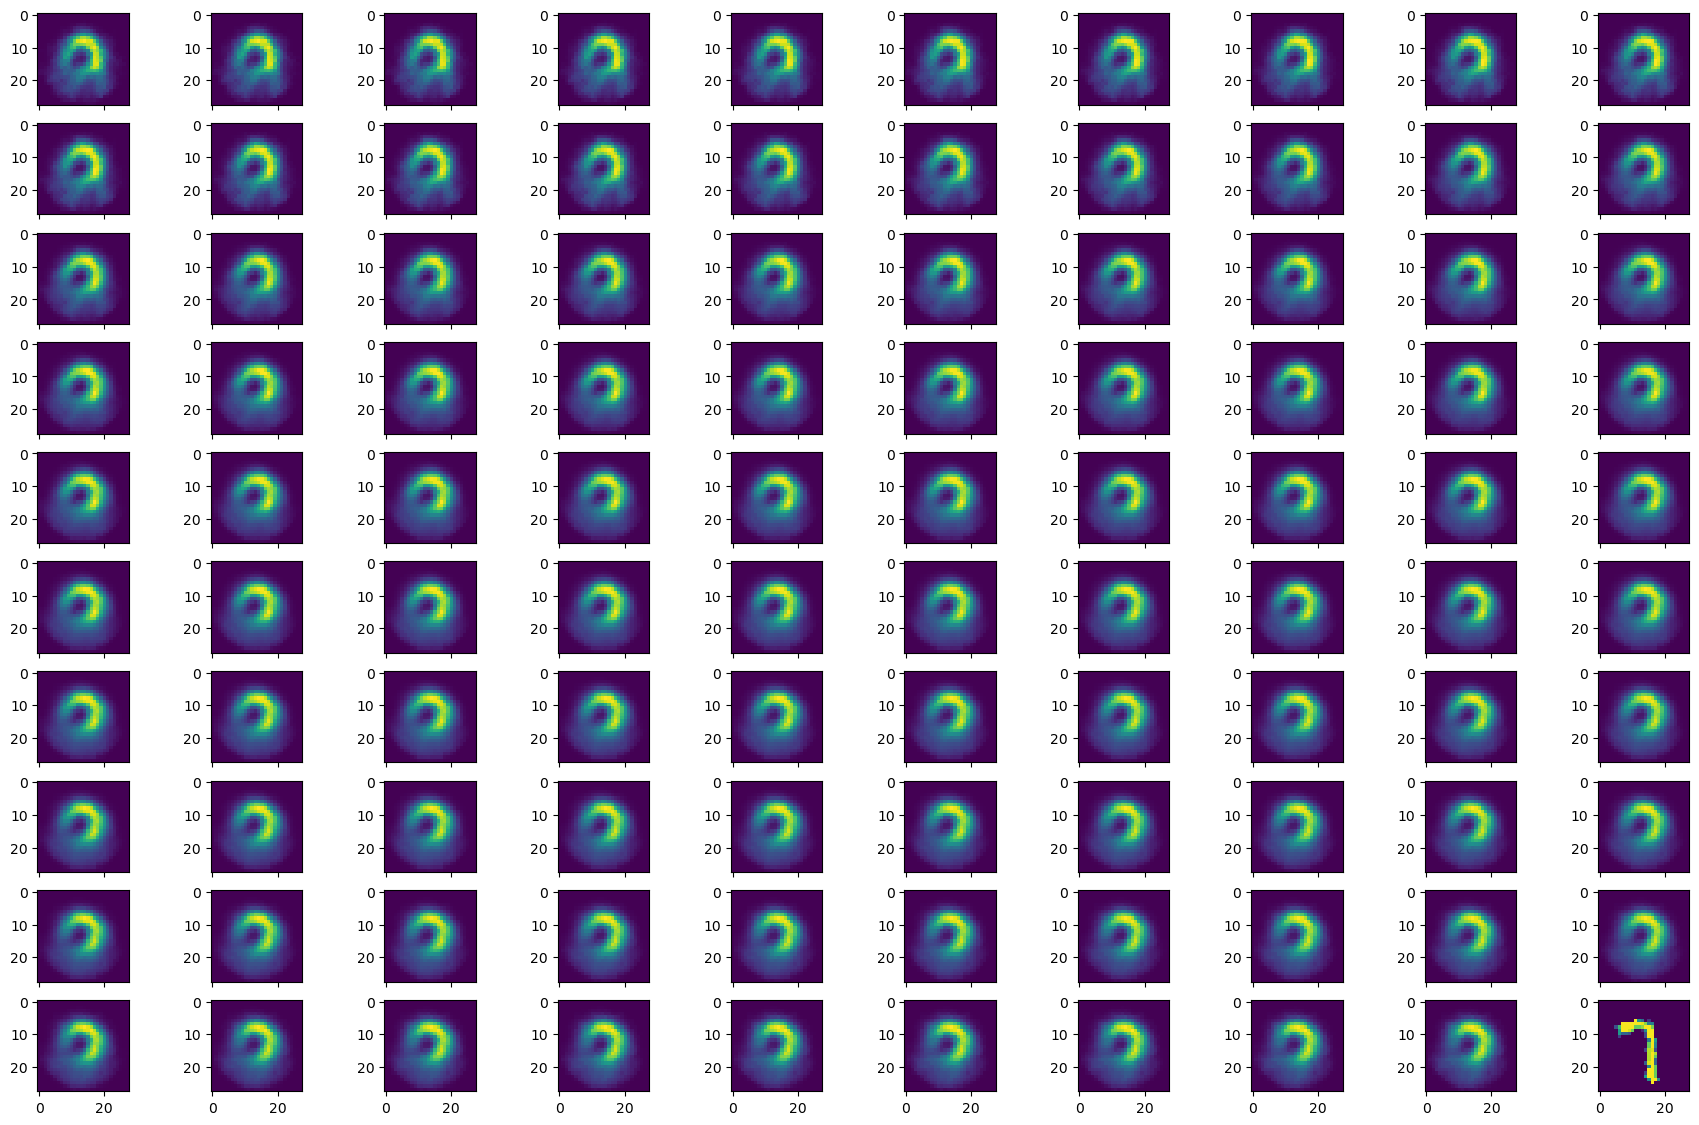

tensor([ 0.2152, -0.3257, -0.1438], grad_fn=<SelectBackward0>)
tensor([ 0.2152,  0.1093, -0.1438], grad_fn=<CopySlices>)


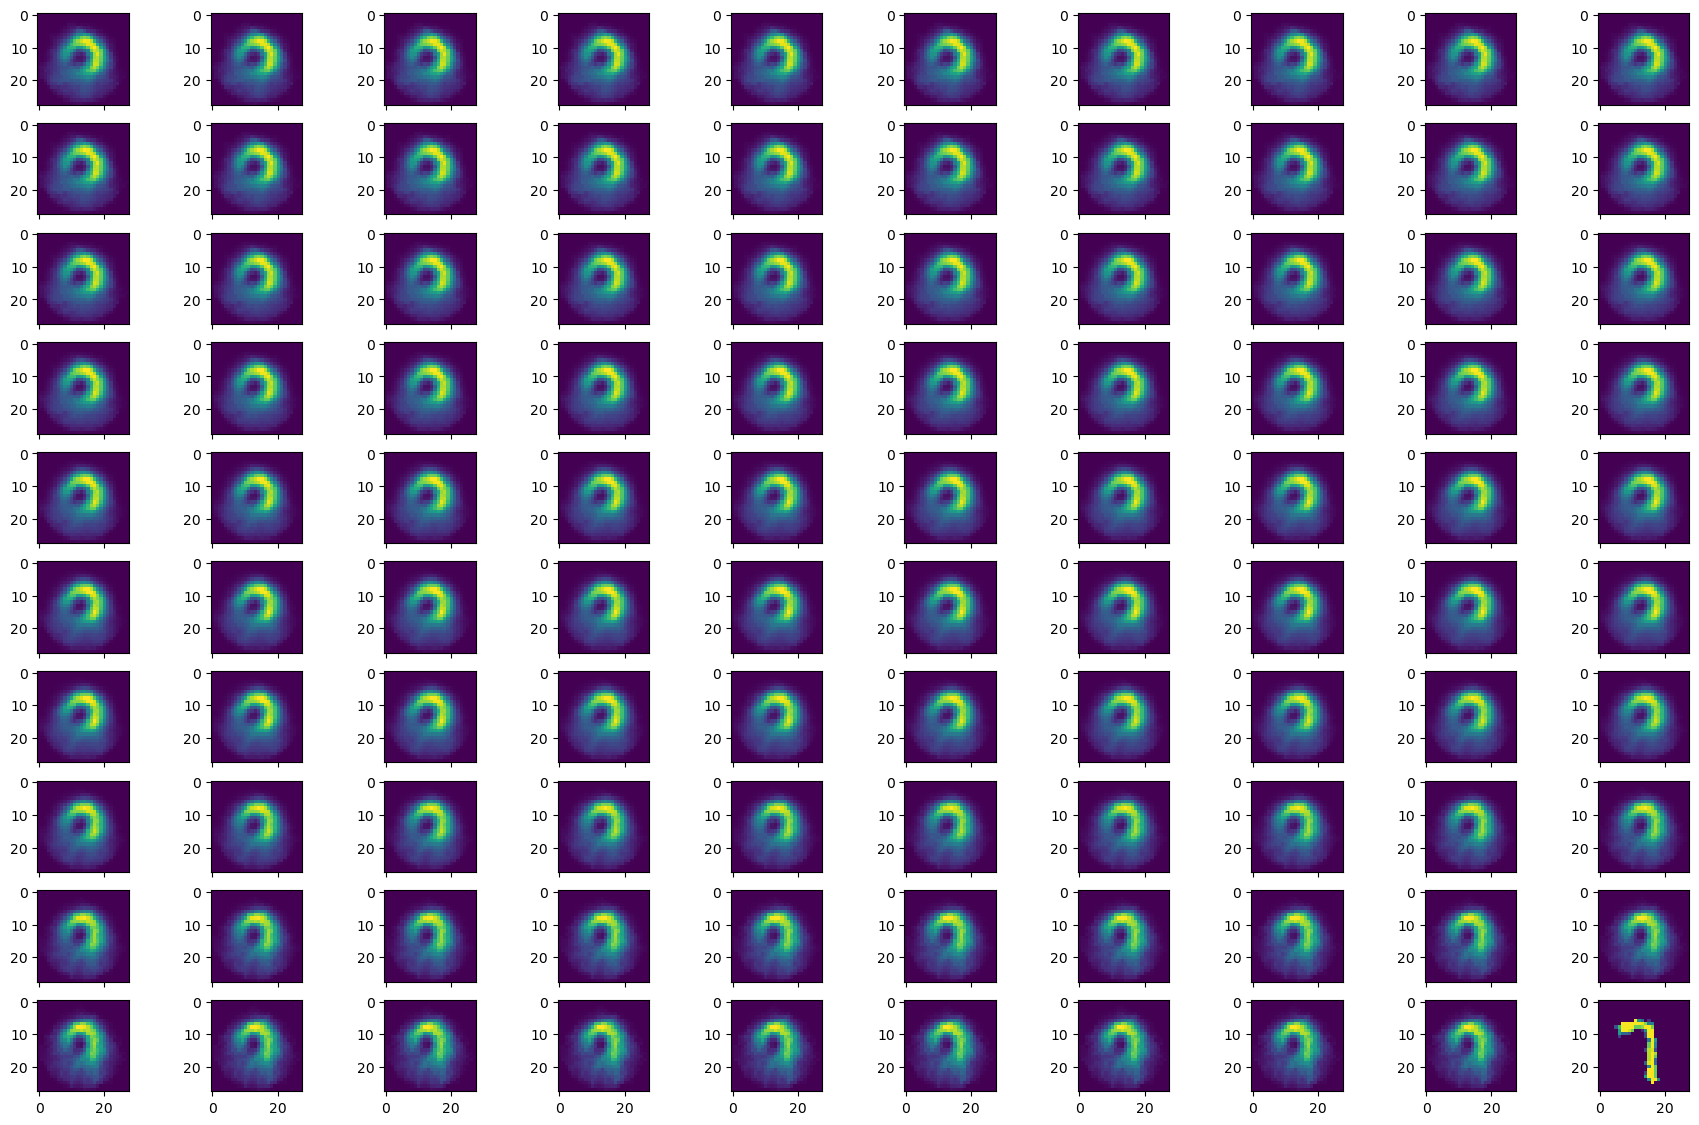

tensor([ 0.2152, -0.3257, -0.1438], grad_fn=<SelectBackward0>)
tensor([ 0.2152, -0.3257,  0.2365], grad_fn=<CopySlices>)


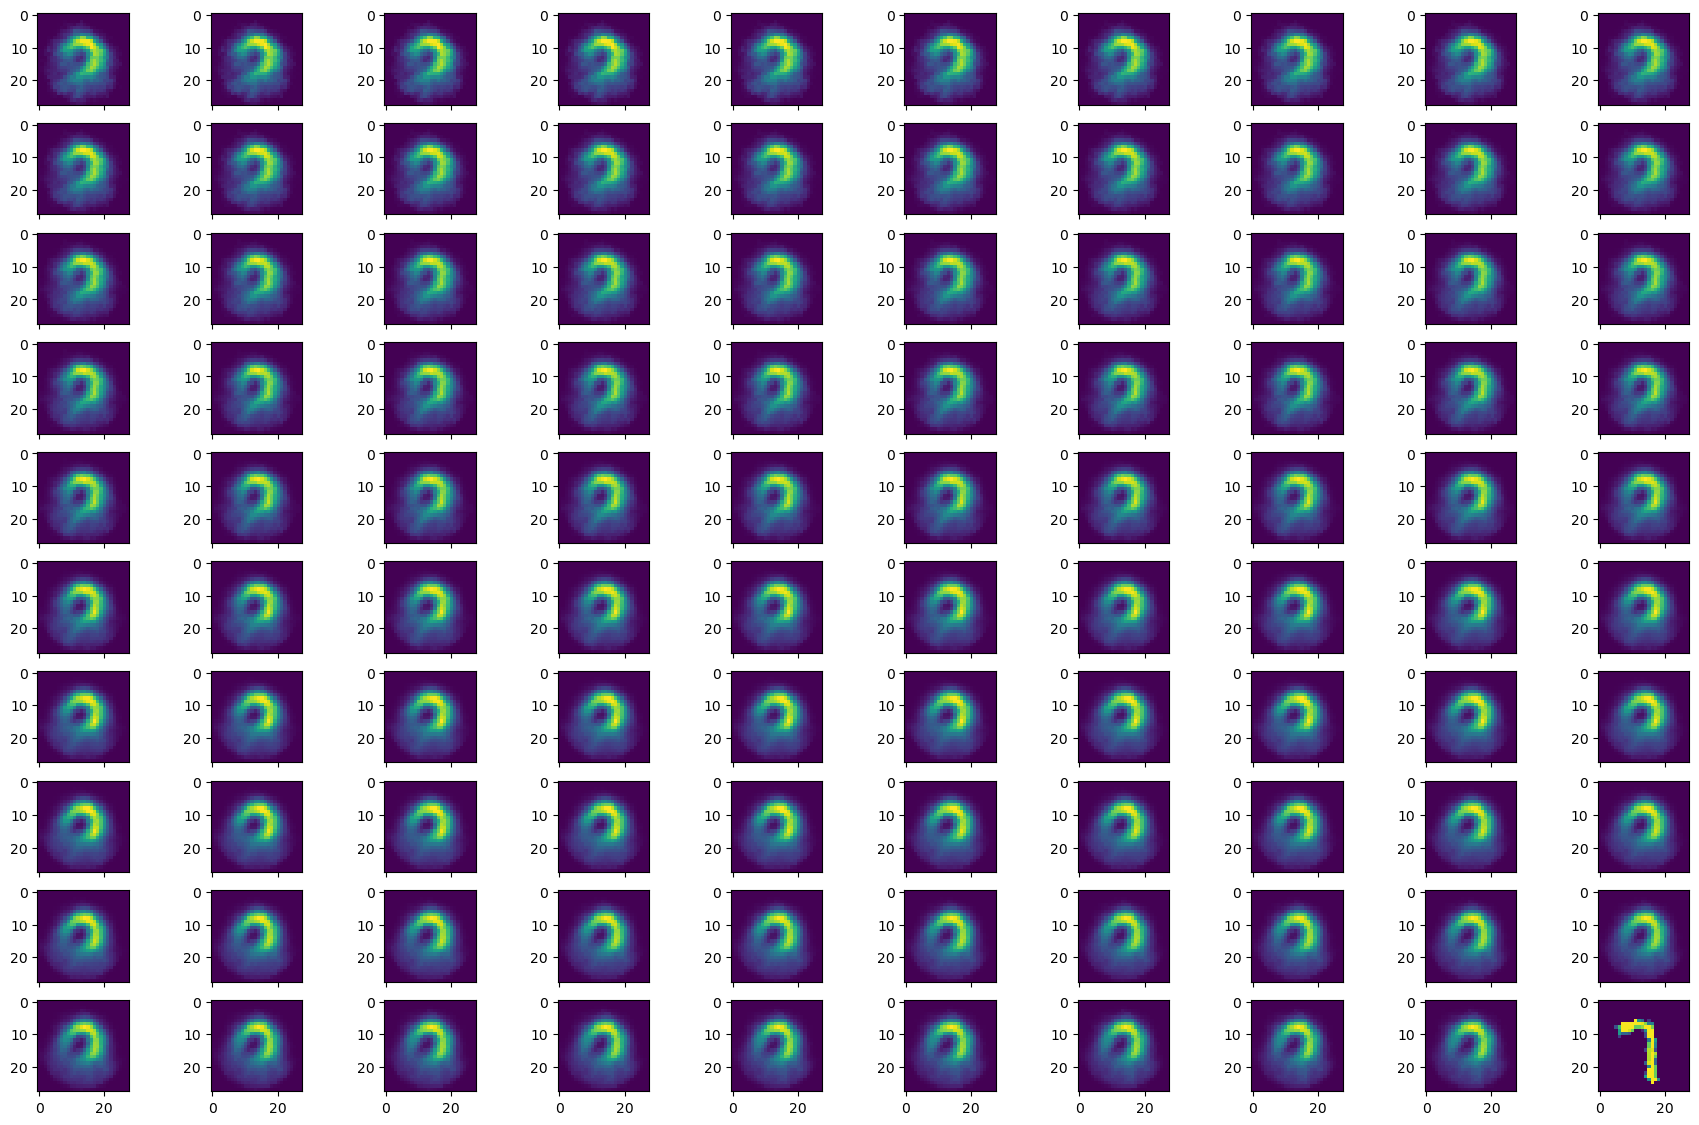

In [17]:
class Encoder(nn.Module):
    def __init__(self, parameters):
        super(Encoder, self).__init__()
        self.l1 = nn.Linear(parameters['in_dim'], 
                            parameters['hidden_dim']
                           )
        self.l2 = nn.Linear(parameters['hidden_dim'], 
                            parameters['latent_dim'])
        self.l3 = nn.Linear(parameters['hidden_dim'], 
                            parameters['latent_dim'])
        
        self.N = torch.distributions.Normal(0, 1)
        # self.N.loc = self.N.loc.cuda() 
        # self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.l1(x))
        
        mu =  self.l2(x)
        sigma = torch.exp(self.l3(x))
        
        
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        
        return z
    
class Decoder(nn.Module):
    def __init__(self, parameters):
        super(Decoder, self).__init__()
        self.l1 = nn.Linear(parameters['latent_dim'], 
                                 parameters['hidden_dim'])
        self.l2 = nn.Linear(parameters['hidden_dim'], 
                                 parameters['in_dim'])

    def forward(self, z):
        z = F.relu(self.l1(z))
        z = torch.sigmoid(self.l2(z))
        z = z.reshape((-1, 1, 28, 28))  
        
        return z
    
    
class VAE(nn.Module):
    def __init__(self, parameters):
        super(VAE, self).__init__()
        self.encoder = Encoder(parameters)
        self.decoder = Decoder(parameters)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train(vae, data, loss_fn, epochs=20):
    opt = torch.optim.Adam(vae.parameters())
    num_batches = len(data)
    train_loss = 0
    for epoch in range(epochs):
        vae.train()
        
        for x in data:
            x = x.to(device) # GPU
            
            opt.zero_grad()
            x_hat = vae(x)
            # loss = loss_fn(x, x_hat)
            
            loss = ((x - x_hat)**2).sum()
            loss = loss + .0005 * vae.encoder.kl
            train_loss = train_loss + loss.item()
            loss.backward()
            opt.step()
            
        train_loss /= num_batches
        
        print(f'\n Epoch {epoch}: train loss {train_loss}')
            
    return vae


class PrepareData(Dataset):
    def __init__(self, X, ):
        super(PrepareData, self).__init__()
        self.X = X

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx]
    
    
def create_dataloader(x, batchsize):
    data = PrepareData(x)
   
    return DataLoader(dataset=data, 
                      shuffle=False, 
                      batch_size=batchsize)
    
def check_latent_vectors(test_loader, vae):
    vae.eval()
    for x in test_loader:
        latent = vae.encoder(x)
        sample_index = randint(0, latent.shape[0] - 1)
        image = latent[sample_index]
        
        max_val = torch.max(latent, 0)
        min_val = torch.min(latent, 0)
        
        for i in range(3):
            max_1 = max_val[0][i].item()
            min_1 = min_val[0][i].item()
            new_image = torch.clone(image)
            all_new = []
            print(image)
            
            increase = (max_1 - min_1)/100
            # print('--- min, max ----')
            # print(max_1)
            # print(min_1)
#             orginal = vae.decoder(image)
#             plt.imshow(original.detach().numpy())
            
#             break
            for index in range(99):
                min_1 = min_1 + increase
                
                new_image[i] = min_1
                
                new = vae.decoder(new_image)
                new = torch.squeeze(new)
            
                all_new.append(new)
                
            print(new_image)
            all_new.append(x[sample_index])
            plot_images(10, 10, f'vae_{i}.png', all_new)
                
        break
        
    return all_new
        
        

def plot_images(column, row, 
                fig_name, input_x
               ):
    j = 0
    k = 0
    indexes = 0
    fig, ax = plt.subplots(row, column, figsize=(22, 14), sharex=True)

    for i in range(row):
        for j in range(column):
            new_ax = ax[i, j]
            
            new_ax.imshow(input_x[indexes].detach().numpy())
            indexes = indexes + 1
            
    fig.savefig(f'{fig_name}', 
            facecolor='white', 
            transparent=False)

    plt.show()
        
def process(parameters):
    latent_dims = 3
    vae = VAE(parameters).to(device) # GPU
    loss_fn = nn.MSELoss(reduction="sum")
    
    train_data = read_file(file_tr)
    test_data = read_file(file_te)
    
    train_loader = create_dataloader(train_data,
                                     parameters['batch']
                                    )
    train(vae, train_loader,
                loss_fn,
                parameters['epoch'])
    
#     torch.save(vae, f'./hw_5_VAE_generative.model')
#     model = VAE(parameters).to(device)
    
    # model = torch.load(f'./hw_5_VAE_generative.model')
    # print(model.state_dict())
    
     
    test_loader = create_dataloader(test_data,
                                     parameters['batch'])
   
    new_images = check_latent_vectors(test_loader, vae)
                           
                           
parameters = {
    'in_dim': 784,
    'hidden_dim': 1024,
    'out_dim': 49,
    # 'baseline_model': 'hw_4_baseline.model',
    'batch': 100,
    'num_layers': 2,
    'type_init': 'xavier',
    'activation': 'ReLU',
    'dropout': None,
    "lr_rate": 0.01,
    'epoch': 300,
    'latent_dim': 3,
}

process(parameters)


 ---------- Dimension 0 ---------- 



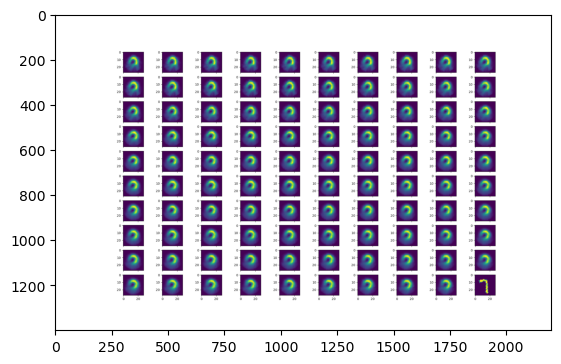


 ---------- Dimension 1 ---------- 



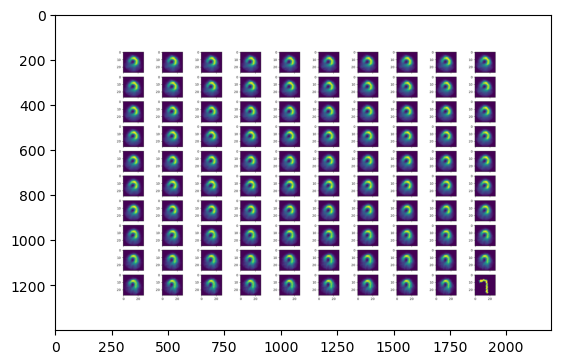


 ---------- Dimension 2 ---------- 



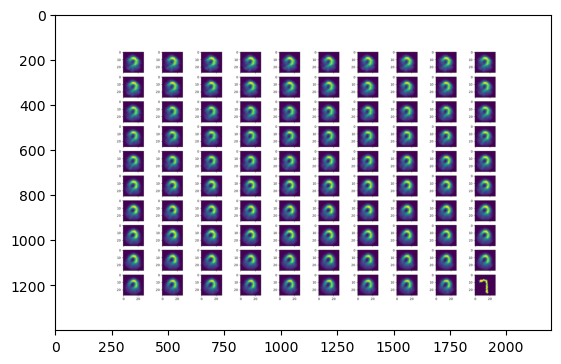

In [18]:
import matplotlib.image as mpimg

#     fig_name = 'hw5_raw_images_generated_10x10.png'

for i in range(3):
    print(f'\n ---------- Dimension {i} ---------- \n')
    fig_name = f'vae_{i}.png'

    img = mpimg.imread(fig_name)
    imgplot = plt.imshow(img)
    plt.show()

# print('\n -------- Generated image ----------- \n')
# img = mpimg.imread(fig_name)
# imgplot = plt.imshow(img)
# plt.show()
